<center>
    <img width='80%' src='rapids_workflow.png'></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>

> 1. Motivate rapids [ show coverage of modern data science tools ]

> 2. Generate a synthetic dataset
    * 2.1 - Split into train and test set
    * 2.2 - Visualize sub-datasets

> 3. ETL
    * 3.1 - Load data [ csv read ]     
    * 3.2 - Transform data [ standard scaler ]

> 4. Model Building 
    * 4.1 - Train CPU and GPU XGBoost classifier models 
    * 4.2 - Use trained models for inference
    * 4.3 - Compare accuracy
    * 4.4 - Visualize sample boosted trees & model predictions

> 5. Extensions 
    * 5.1 - Create an ensemble with a clustering model [ DBScan ]
    * 5.2 - Export data to DeepLearning Framework [ PyTorch ]
    


In [159]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy
from numba import cuda 

import ipyvolume as ipv
import matplotlib.pyplot as plt
from fig_helpers import *
import time

In [164]:
def set_rcParams():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams.update({'figure.figsize': (15,10)})
    plt.rcParams.update({'figure.subplot.top': .99})
    plt.rcParams.update({'figure.subplot.left': .01})
    plt.rcParams.update({'figure.subplot.right': .99})
    

------
# 1. Motivation: Kaggle 2018 and 2017 Data Science Surveys
<img width='1200px' src='https://storage.googleapis.com/kaggle-datasets-images/70947/156853/3ef5dd03338ef20b7c6118e4ed600a87/dataset-cover.jpg?t=2018-11-05-19-24-06'></img> 
* https://www.kaggle.com/surveys/2018
* https://www.kaggle.com/surveys/2017

In [2]:
schemaFilePath_2018 = 'kaggle_data/2018/SurveySchema.csv'
schemaSurveyDF_2018 = pd.read_csv(schemaFilePath_2018)

surveyFilePath_2018 = 'kaggle_data/2018/multipleChoiceResponses.csv'
kaggleSurveyDF_2018 = pd.read_csv(surveyFilePath_2018, encoding="ISO-8859-1", low_memory=False)

schemaFilePath = 'kaggle_data/2017/schema.csv'
schemaSurveyDF = pd.read_csv(schemaFilePath)

surveyFilePath = 'kaggle_data/2017/multipleChoiceResponses.csv'
kaggleSurveyDF = pd.read_csv(surveyFilePath, encoding="ISO-8859-1", low_memory=False)

scrapedKernelMethodFilePath = 'kaggle_data/results.csv'
kaggleKernelMethodsDF = pd.read_csv(scrapedKernelMethodFilePath)

# Select any activities that make up an important part of your role at work


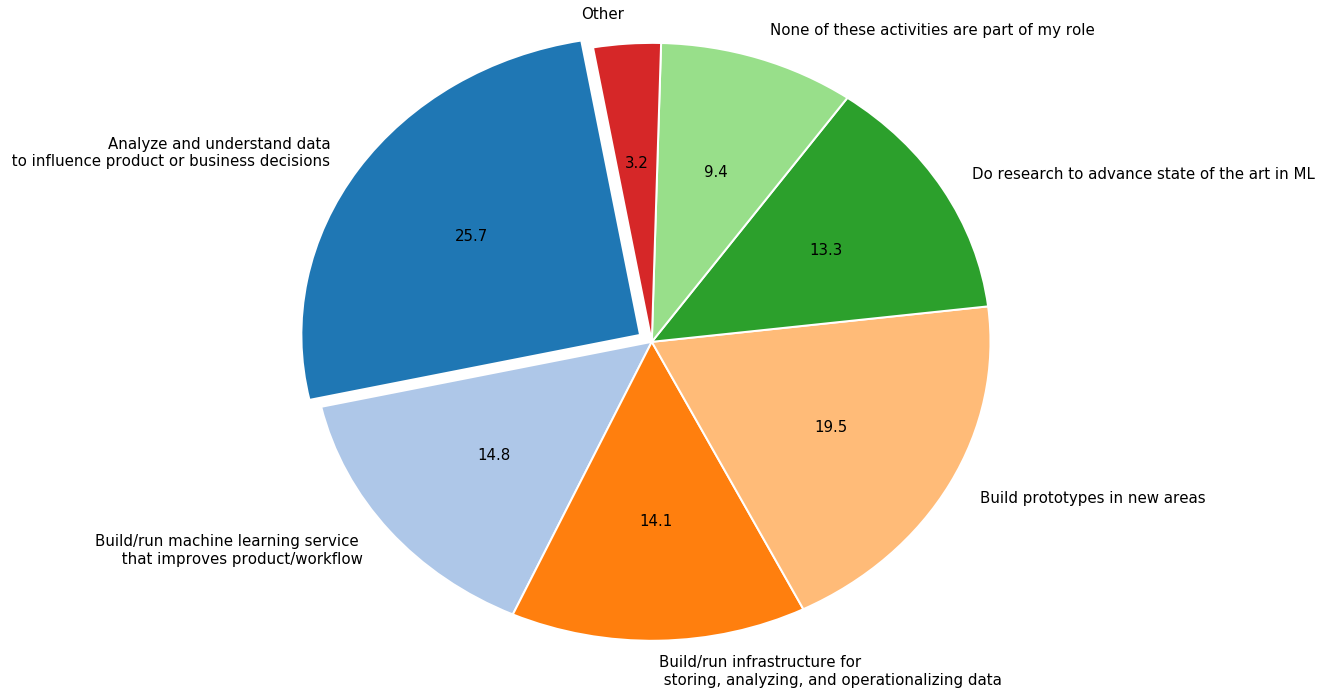

In [68]:
pie_plot_important_activities_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018 )

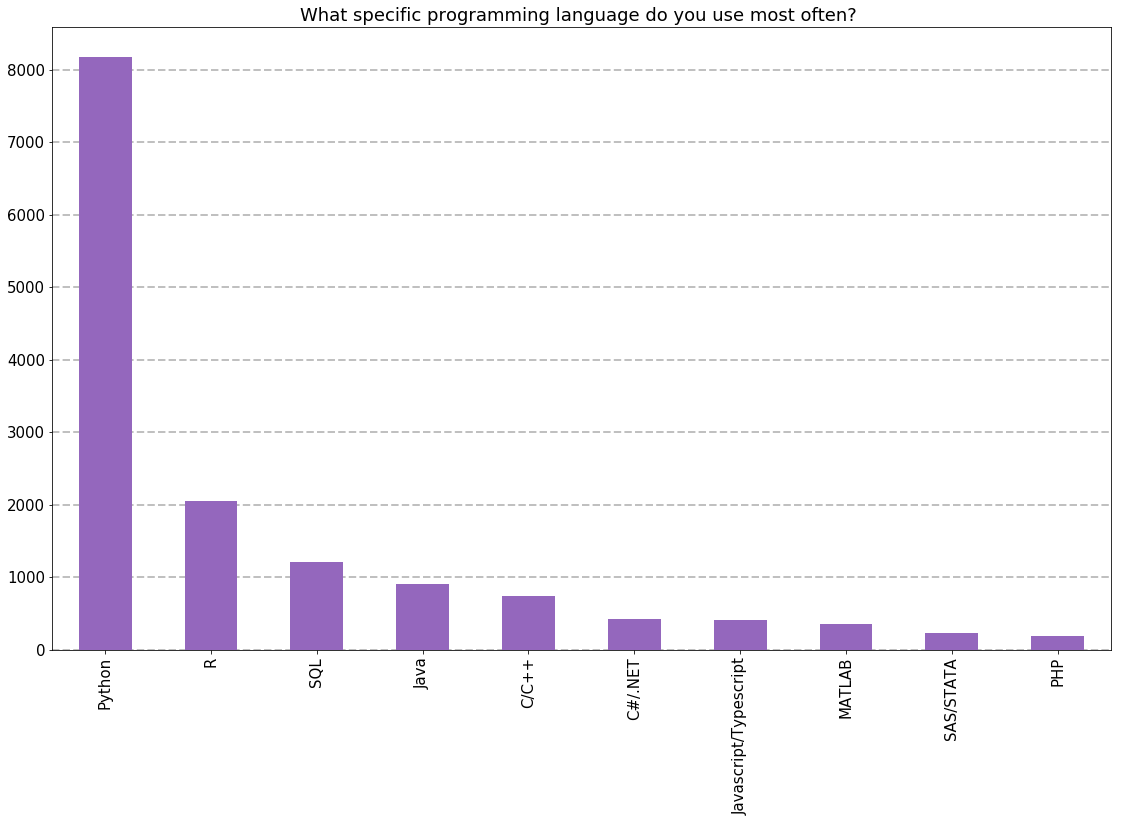

In [165]:
set_rcParams(); bar_plot_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018, 17)

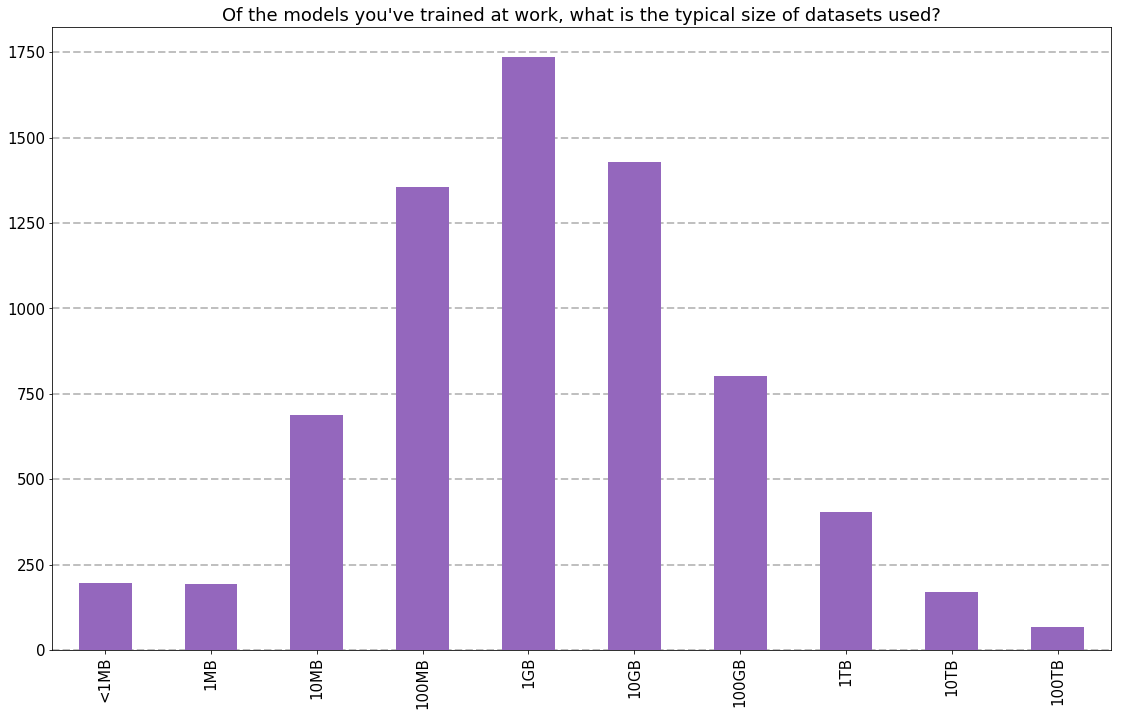

In [166]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 119, nTopResults = 10, 
                  newIndex = ['<1MB', '1MB', '10MB', '100MB','1GB', '10GB',  '100GB', '1TB', '10TB', '100TB'])

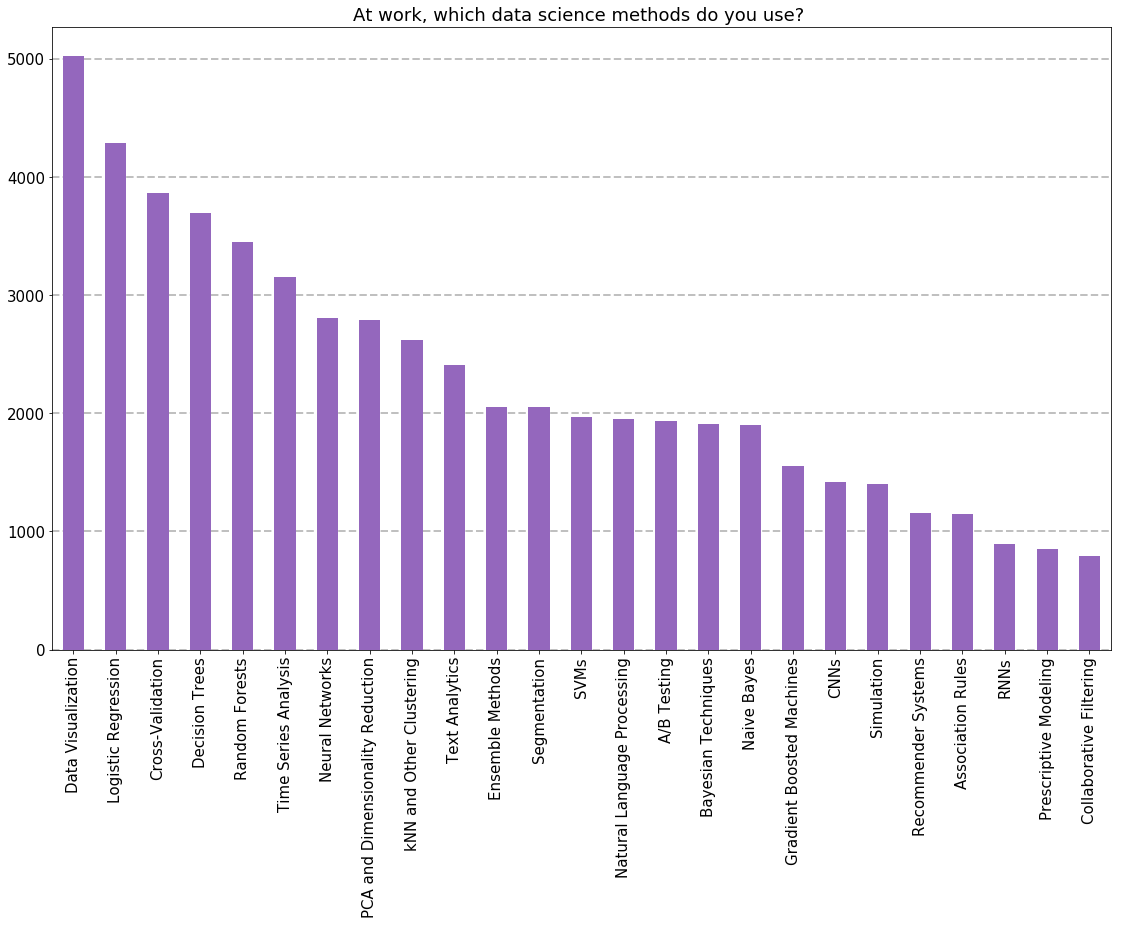

In [167]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 180, 25)

# Top pandas dataframe methods used 
> [ code scraped from top 1800 Kaggle notebooks ]

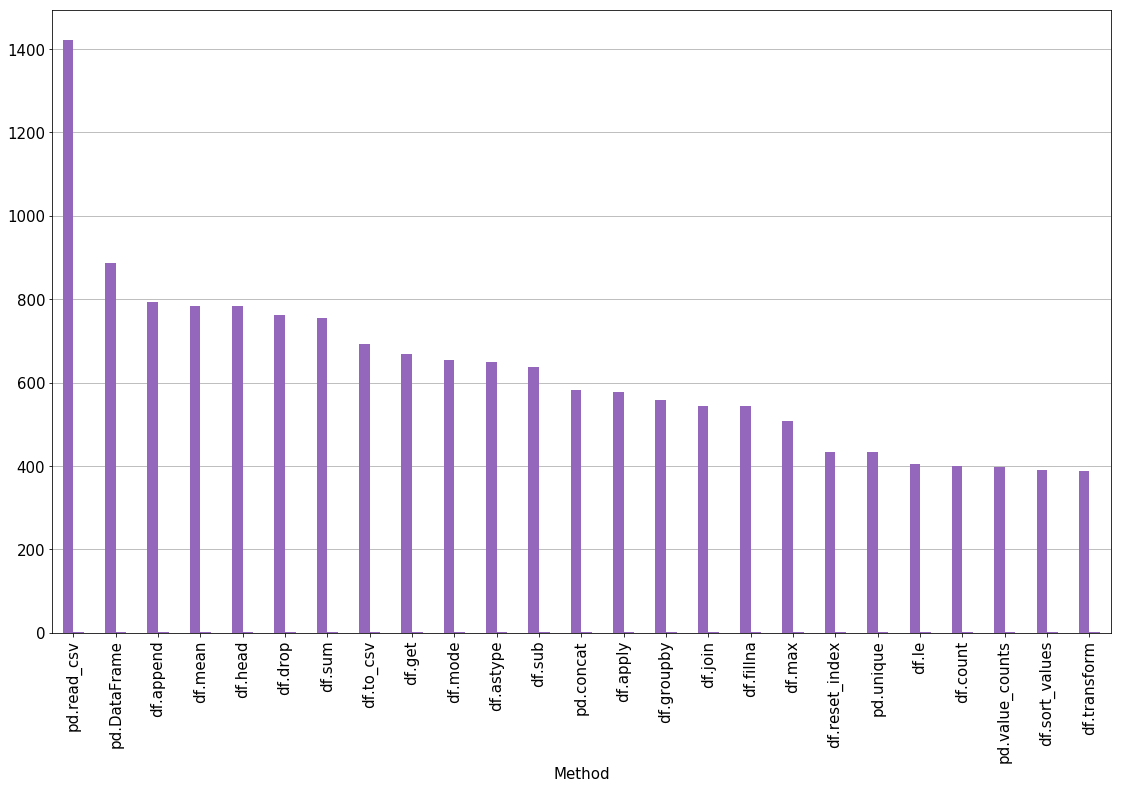

In [168]:
kaggleKernelMethodsDF.index = kaggleKernelMethodsDF['Method']
kaggleKernelMethodsDF.head(25).plot.bar(legend=False, alpha=1, color='tab:purple', rot=90); plt.gca().set_axisbelow(True); plt.gca().yaxis.grid(True)

-----
# 2. Generate Dataset [ X: features, y: labels ]

Set the size of the generated dataset -- the number of total samples is determined by this value

In [11]:
nTotalSamples = 100000

Next we'll use <a href='https://scikit-learn.org/stable/datasets/index.html#generated-datasets'>sklearn.datasets</a> to build synthetic sub-datasets of the size we specified above. We'll build three sub-datasets and combine them together and then use a trained model to see if we can determine which of sub-dataset a sample belongs to. The three sub-datasets are built using the moons, blobs, and swiss-roll generators. These sub-datasets were selected for their distinct visual features.

In [12]:
%%time
nSamplesPerSubDataset = nTotalSamples//3

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerSubDataset, noise = .005)[0]

moonsDataset = datasets.make_moons(n_samples = nSamplesPerSubDataset, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*4

blobsDataset = datasets.make_blobs( n_samples = nSamplesPerSubDataset, centers = 5,  n_features = 3, 
                                    cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]

X = np.vstack([blobsDataset, moonsDataset, swissRollDataset])

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 24.4 ms


In [13]:
# generate labels for classification 
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

y = np.hstack( [blobsLabels, moonsLabels, sRollLabels] )

In [14]:
X.shape, y.shape

((99999, 3), (99999,))

## 2.1 - Split Train (75%) and Test (25%) Data 
We split our combined dataset into two portions:
* **train-set** - which we'll use to optimize our model's parameters [ train-set = randomly selected 75% of total data]
* **test-set** - which we'll use to evaluate how well our trained model performs on unseen data [ test-set = remaining 25% of data ]

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 0, shuffle=True)

In [16]:
len(X_train), len(X_test)

(74999, 25000)

## 2.2 - Visualize Data
We define a function for WebGL based 3D plotting using the <a href='https://github.com/maartenbreddels/ipyvolume'>ipyvolume</a> library -- we restrict the maximum points to plot to `maxSamplesToPlot` which has a default setting of `100000`

In [17]:
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure(width=600,height=600)
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()


## Sub-Datasets [ moons, blobs, swiss-roll ] 

In [169]:
ipv_plot_data( moonsDataset)

In [170]:
ipv_plot_data( blobsDataset )

In [171]:
ipv_plot_data( swissRollDataset )

## Combined Dataset Plot
The train-set is shown in purple and the test-set is show in yellow.

In [172]:
%time
ipv.figure()
ipv_plot_data( X_train, 'purple', 200000, True)
ipv_plot_data( X_test, 'yellow', 1000, True, 1)
ipv.show()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.3 µs


------
# 3. ETL 
First we write the dataset to disk (as a comma separated file - CSV) so that we can subsequently demonstrate data loading.

In [22]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 664 ms, sys: 48 ms, total: 712 ms
Wall time: 712 ms


In [23]:
!echo 'no data\n0' > warmup.csv # write a mini csv file used to initialize cuIO kernels

## Check Size of Data on Disk 
using the default value of `nTotalSamples = 5000000` should produce a training set of `~184MBs` in size.

In [24]:
!du -h *csv.txt

1.3M	X_test.csv.txt
3.7M	X_train.csv.txt
100K	y_test.csv.txt
296K	y_train.csv.txt


# 3.1 - Load Data

In [25]:
%%time 
startTime = time.time()

pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

pandasIngestionTime = time.time() - startTime

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 77.6 ms


In [26]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()
# warmup rapids data ingestion engines [ cuio kernels ]
cudf.read_csv('warmup.csv')

<cudf.DataFrame ncols=1 nrows=1 >

In [27]:
%%time
startTime = time.time()

cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', dtype=['float64'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', dtype=['float64'])

rapidsIngestionTime = time.time() - startTime

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 48 ms


## Evaluate Load/Ingestion Speedup

In [28]:
pandasIngestionTime/rapidsIngestionTime

1.6175119103269249

# 3.2 - Transform Data ( Normalize )
Transforming a dataset is a common requirement prior to training upstream models. For each feature in the dataset we remove the mean and divide by the standard deviation -- this makes each feature behave like a normally distributed variable (e.g. gaussian with 0 mean and unit variance). 

For the data on the CPU we can use the pre-built <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>sklearn.preprocessing.StandardScaler</a> function.
In the case of the GPU, we demonstrate how the same transformation can be built using a custom (user defined) function written as a <a href='http://numba.pydata.org/numba-doc/0.13/CUDAJit.html'>just-in-time numba kernel</a>. 

Note that we compute the mean and standard deviation statistics on the training data, and then apply the transformation to the training and test data (i.e., the test data is never seen when computing the mean & standard deviation).

In [29]:
%%time 
startTime = time.time()

scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

pandasTransformTime = time.time() - startTime 

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.64 ms


-----

In [30]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [31]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
        scaledDF.add_column(name=iColName, data = outputCol)    
        
    return scaledDF, trainMeans, trainStdevs

In [32]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup

In [33]:
%%time
startTime = time.time()

cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

rapidsTransformTime = time.time() - startTime

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 36.9 ms


## Evaluate Transform Speedup

In [34]:
pandasTransformTime/rapidsTransformTime

0.17961177595699035

## Verify [approximate] numerical equivalence between CPU and GPU

In [35]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.2852054718047046, '1': 6.019116890252761, '2': 0.466293531891778},
 array([1.28520547, 6.01911689, 0.46629353]),
 {'0': 4.5197702276405645, '1': 5.751743081550643, '2': 5.229570029144451},
 array([4.5197401 , 5.75170474, 5.22953516]))

In [36]:
print(pd_X_test[0:2,:])

[[-0.02051526  0.68194871 -1.77652262]
 [-0.29127749 -0.35106797 -0.08916539]]


In [37]:
print(cudf_X_test.head(2))

                     0                     1                     2
0 -0.02051511987913237    0.6819441679096779   -1.7765107729319827
1  -0.2912755468578917  -0.35106562836915184  -0.08916479352684878


-----
# 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## Prepare Data for Training

In [38]:
X = pd_X_train
y = pd_y_train

In [39]:
X_gpu = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
y_gpu = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:604: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:605: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Specify Model Parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

In [173]:
cpuMaxDepth = 3 # default
nTrees = 100 # default

gpuMaxDepth = 10

nCores = !nproc --all
nCores = int(nCores[0])

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'n_estimators': nTrees,
    'n_gpus': 1,
    'tree_method': 'gpu_hist',
    'objective': 'gpu:reg:linear', 
    'random_state': 0,
    'verbose_model': True
}
paramsCPU = {
    'max_depth': cpuMaxDepth,
    'n_estimators': nTrees,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'n_jobs': nCores
}

-----
# 4.1 - Model Training

## Train on **CPU**

In [174]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                        n_estimators = paramsCPU['n_estimators'],
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],                                        
                                        n_jobs = paramsCPU['n_jobs'])

In [175]:
xgBoostModelCPU, print("using {} CPU cores for parallel xgboost training".format(nCores))

using 40 CPU cores for parallel xgboost training


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=40, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
        subsample=1, tree_method='hist', verbosity=1), None)

In [176]:
%%time
startTime = time.time()

xgBoostModelCPU.fit( X, np.squeeze(y) );

cpuXGBoostTime = time.time() - startTime

CPU times: user 18 s, sys: 21.7 s, total: 39.7 s
Wall time: 1.03 s


## Train on **GPU**

In [177]:
%%time
startTime = time.time()

xgBoostModelGPU = xgboost.train( dtrain = X_gpu, params = paramsGPU)

gpuXGBoostTime = time.time() - startTime

[20:09:15] WARNING: /rapids/xgboost/src/objective/regression_obj.cu:152: gpu:reg:linear is now deprecated, use reg:linear instead.
CPU times: user 92 ms, sys: 28 ms, total: 120 ms
Wall time: 113 ms


## Evaluate Training Speedup

In [178]:
cpuXGBoostTime/gpuXGBoostTime

9.11005231178581

-----
# 4.2 - Model Inference

## Infer/predict using Trained **CPU** Model

In [46]:
%%time
startTime = time.time()

yPredTrain = xgBoostModelCPU.predict(pd_X_train)
yPredTest = xgBoostModelCPU.predict(pd_X_test)

cpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 2.13 s, sys: 76 ms, total: 2.2 s
Wall time: 55.8 ms


## Infer/predict using Trained **GPU** Model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [47]:
# convert continuous prediction to a multi-class option
def continuous_to_discrete( data, nClasses = 3):
    data[data>nClasses-1] = nClasses-1 # filter values beyond the possible classes
    return np.abs(np.round(data))

In [48]:
%%time
startTime = time.time()

yPredTrain_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(X_gpu) )
yPredTest_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(y_gpu) )

gpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 84 ms, sys: 8 ms, total: 92 ms
Wall time: 2.48 ms


## Evaluate Inference Speedup

In [49]:
cpuXGBoostInferenceTime/gpuXGBoostInferenceTime

22.920376544420474

-----
# 4.3 - Evaluate Accuracy

In [50]:
print( 'CPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest) ))
print( 'GPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest_GPU) ))

CPU test accuracy: 0.999840 
GPU test accuracy: 0.999480 


TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [51]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest))


 confusion matrix on TRAIN data -- 
[[25041     0     1]
 [    0 24913     0]
 [    0    11 25033]]

 confusion matrix on TEST data -- 
[[8290    0    1]
 [   0 8420    0]
 [   0    3 8286]]


In [52]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain_GPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest_GPU))


 confusion matrix on TRAIN data -- 
[[25040     2     0]
 [    0 24913     0]
 [    0     3 25041]]

 confusion matrix on TEST data -- 
[[8283    4    4]
 [   0 8420    0]
 [   0    5 8284]]


# 4.4 - Visualize Model Outputs

## Visualizing a CPU boosted tree

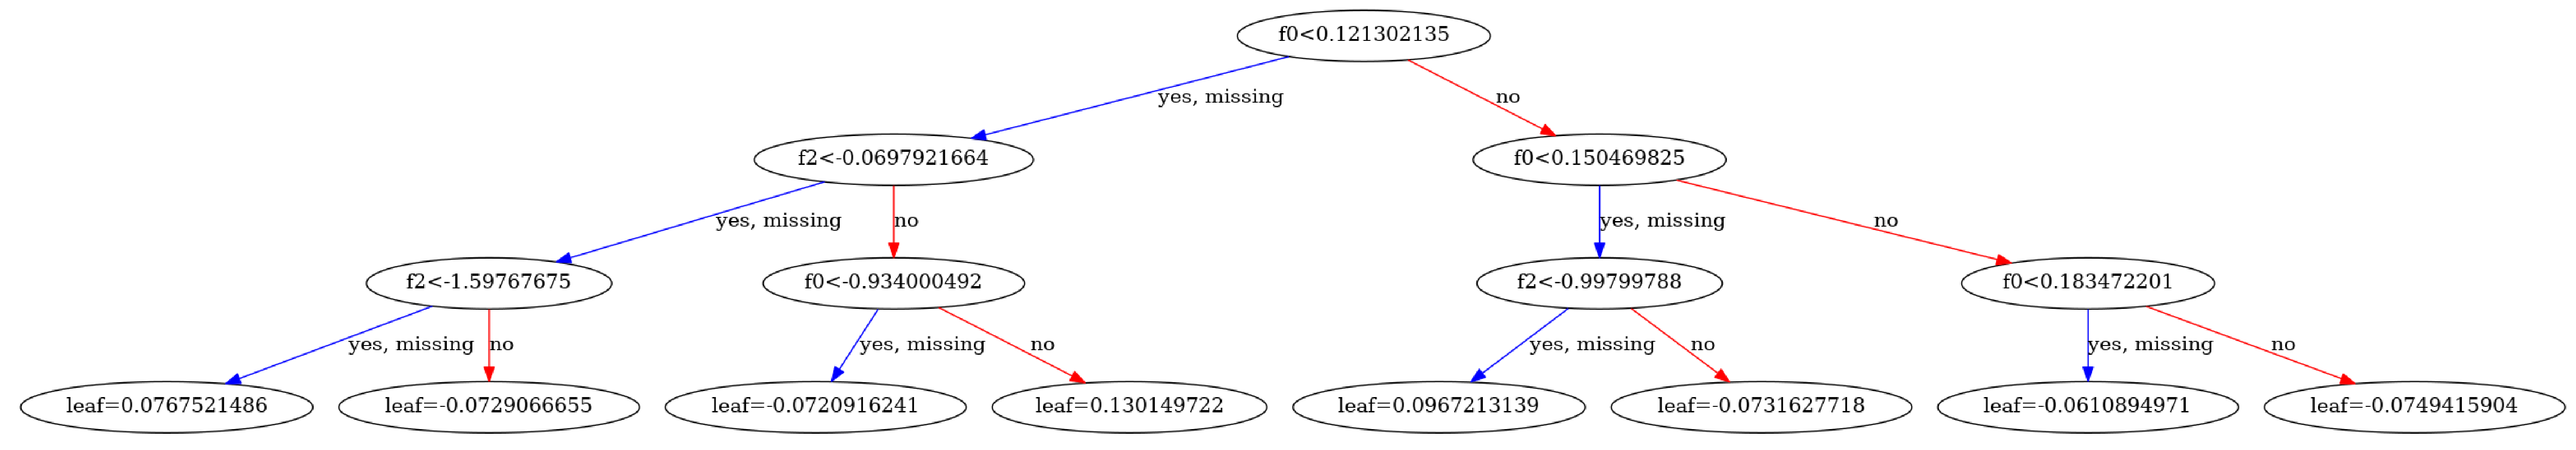

In [53]:
fig = plt.figure(figsize=(100,15))
plot_tree(xgBoostModelCPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualizing a GPU Boosted Tree

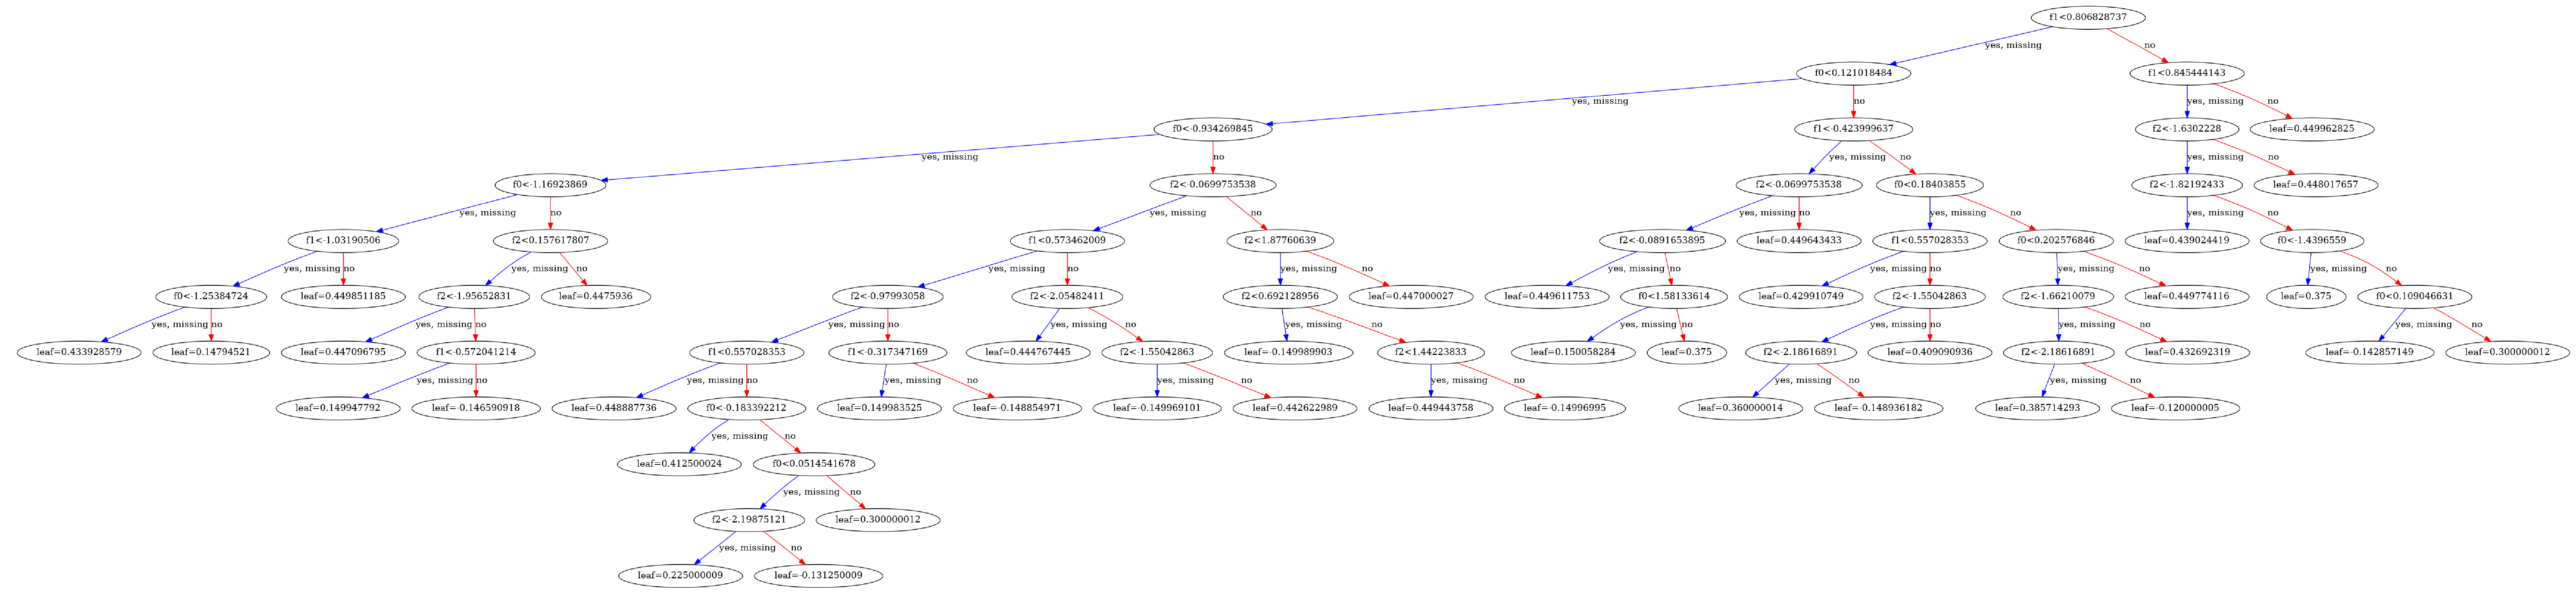

In [54]:
fig = plt.figure(figsize=(100,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualize Class Predictions

In [55]:
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [153]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTest_GPU.astype(np.int), topK=None )

In [154]:
ipv_plot_data( pd_X_test, colorStack= colorStackClassifier)

-------
# Extensions
-------

# Ext.1 : Growing the Model Ensemble ( DBScan Clustering )

<img width='95%' src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png'>

## DBScan via sklearn [ CPU ]

In [90]:
# sub-sample
nSamplesToCluster = 20000
pd_X_test_sampled = pd_X_test[:nSamplesToCluster, :]  
cudf_X_test_sampled = cudf_X_test.loc[0:nSamplesToCluster,list(cudf_X_test.columns)]

In [91]:
%%time
startTime = time.time()

dbScanModel = DBSCAN( min_samples = 10, n_jobs = nCores ).fit(pd_X_test_sampled)
labels = dbScanModel.labels_

sklearnDBScanTime = time.time() - startTime

CPU times: user 6.31 s, sys: 36 ms, total: 6.34 s
Wall time: 506 ms


## DBScan via cuml [ GPU ]

In [92]:
%%time
startTime = time.time()

clustering_cuml = cuml.DBSCAN( eps = .15 , min_samples = 200 )
clustering_cuml.fit( cudf_X_test_sampled )

rapidsDBScanTime = time.time() - startTime

CPU times: user 292 ms, sys: 72 ms, total: 364 ms
Wall time: 365 ms


In [93]:
%%time
print( clustering_cuml.labels_.value_counts() )

2    7540
5    3423
1    3330
4    1366
3    1338
6    1298
0    1283
-1     423
dtype: int64
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 14.4 ms


## Evaluate Clustering Speedup

In [94]:
sklearnDBScanTime/rapidsDBScanTime

1.3887654573720882

## Map Clusters to Colors and Visualize

In [95]:
%%time
colorStack = map_colors_to_clusters_topK( pd_X_test, clustering_cuml.labels_, nSamplesToCluster  )

CPU times: user 2.28 s, sys: 52 ms, total: 2.33 s
Wall time: 2.33 s


In [96]:
def colored_topK ( dataset, topK = None):    
    if topK == None:
        topK == dataset.shape[0]
        
    return lambda dataset, colorStack, topK : ipv.quickscatter( dataset[0:topK, 0], 
                                                                dataset[0:topK, 1], 
                                                                dataset[0:topK, 2], 
                                                                size = .5, marker = 'sphere', 
                                                                color = colorStack)  

In [97]:
colored_topK( pd_X_test_sampled, nSamplesToCluster )(pd_X_test_sampled, colorStack, nSamplesToCluster)

# ....

# Ext.2 : Bridge to Deep Learning [ Rapids -> PyTorch via DLPack ]

## Wrap RAPIDS DataFrames into PyTorch.Tensor Objects 

In [104]:
import torch
from torch.utils import dlpack, data
import torch.nn as nn

dlpackedTrain = cudf_X_train.to_dlpack()
dlpackedTrainLabels = cudf_y_train.to_dlpack()

trainData = torch.cuda.FloatTensor(dlpack.from_dlpack ( dlpackedTrain ).float())
trainLabels = torch.cuda.FloatTensor(dlpack.from_dlpack ( dlpackedTrainLabels ).float())

## Prepare dataset for batch [ shuffled ] ingestion

In [105]:
device = torch.device('cuda:0')

combinedDataAndLabels = torch.zeros([cudf_X_train.shape[0], cudf_X_train.shape[1]+1], dtype=torch.float32, device=device)

combinedDataAndLabels[:,:3] = trainData; 
combinedDataAndLabels[:,-1] = trainLabels

trainDataLoader = torch.utils.data.DataLoader( combinedDataAndLabels, batch_size = 4, shuffle = True )

## Define network architecture

In [123]:
nnModel = nn.Sequential(
    nn.Linear(3,25), nn.Sigmoid(), nn.Dropout(.1),
    nn.Linear(25, 25), nn.Sigmoid(), nn.Dropout(.1),
    nn.Linear(25, 25), nn.Sigmoid(), nn.Dropout(.1),
    nn.Linear(25, 25),
    nn.Linear(25, 1)    
)

nnModel = nn.DataParallel(nnModel)
nnModel = nnModel.to(device)

optimizer = torch.optim.Adam(nnModel.parameters())

## Train

In [133]:
for iEpoch in range(3):
    
    for i, iInputBatch in enumerate( trainDataLoader ):
        if i > 20000: # limit number of batches per epoch
            break
            
        iInputBatch = iInputBatch.to(device)
        optimizer.zero_grad()
        
        data = iInputBatch[:,:3]
        labels = iInputBatch[:,-1]
        
        outputs = nnModel.forward(data)
        
        lossFunction = nn.MSELoss()(outputs[:,0], labels)        
        lossFunction.backward()

        lossAvg = lossFunction.mean()
        
        if i % 1000 == 0:
            print('epoch: {}, batch: {: <5} batchLoss: {}'.format(iEpoch, i, lossAvg))
            
        optimizer.step()

epoch: 0, batch: 0     batchLoss: 0.01648864895105362
epoch: 0, batch: 1000  batchLoss: 0.023133205249905586
epoch: 0, batch: 2000  batchLoss: 0.0825645923614502
epoch: 0, batch: 3000  batchLoss: 0.1899794042110443
epoch: 0, batch: 4000  batchLoss: 0.03533681854605675
epoch: 0, batch: 5000  batchLoss: 0.02002563327550888
epoch: 0, batch: 6000  batchLoss: 0.0192774198949337
epoch: 0, batch: 7000  batchLoss: 0.042257845401763916
epoch: 0, batch: 8000  batchLoss: 0.034061577171087265
epoch: 0, batch: 9000  batchLoss: 0.012774228118360043
epoch: 0, batch: 10000 batchLoss: 0.014002293348312378
epoch: 0, batch: 11000 batchLoss: 0.06551722437143326
epoch: 0, batch: 12000 batchLoss: 0.01703980192542076
epoch: 0, batch: 13000 batchLoss: 0.045782431960105896
epoch: 0, batch: 14000 batchLoss: 0.02049160748720169
epoch: 0, batch: 15000 batchLoss: 0.0088023217394948
epoch: 0, batch: 16000 batchLoss: 0.3663354516029358
epoch: 0, batch: 17000 batchLoss: 0.019324488937854767
epoch: 0, batch: 18000 bat

## Plot predictions

In [137]:
predictions = nnModel.forward(combinedDataAndLabels[:,:3]).round()
cpuPredictions = np.squeeze(predictions.to('cpu').detach().numpy()).astype(np.int)
cpuXYZ = combinedDataAndLabels[:,:3].to('cpu').numpy()

cmap = plt.get_cmap('tab10')

ipv.figure()
pointsToPlot = 100000
cmap = np.array(plt.get_cmap('tab10').colors)

ipv.scatter(np.array(cpuXYZ[:pointsToPlot,0]),
            np.array(cpuXYZ[:pointsToPlot,1]),
            np.array(cpuXYZ[:pointsToPlot,2]), color=cmap[cpuPredictions[:pointsToPlot]], marker='sphere')
    
ipv.show()

-----
# End [ thanks! ]

please provide feedback/suggestions and errata @ https://github.com/miroenev/rapids